In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
plt.close('all')
plt.rc('text', usetex=False)
# plt.rc('font', family='serif')
LEGEND_FONT_SIZE = 12
AXIS_FONT_SIZE = 10
TICKS_FONT_SIZE = 10
TITLE_FONT_SIZE = 12
linewidth=2.0
lw=1.2
current_palette = sns.color_palette()

matplotlib.rcParams["xtick.labelsize"] = TICKS_FONT_SIZE

In [3]:
data = pd.read_csv("listings.csv", low_memory=False) 

In [4]:
print(", ".join(data.columns))

id, listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_m

In [5]:
kept_columns = ["host_is_superhost", "neighbourhood", 'latitude','longitude', "accommodates", 
                "bathrooms", "bedrooms", "square_feet", "price", "guests_included", "number_of_reviews",
                "review_scores_rating", "instant_bookable"]

response = "price"
covariates = [c for c in kept_columns if c != response]

In [6]:
data = data[kept_columns]

In [7]:
data.head()

,host_is_superhost,neighbourhood,latitude,longitude,accommodates,bathrooms,bedrooms,square_feet,price,guests_included,number_of_reviews,review_scores_rating,instant_bookable
0,t,Indische Buurt,52.36575,4.94142,2,1.5,1.0,NaN,$59.00,1,277,98.0,t
1,f,Grachtengordel,52.36509,4.89354,2,1.0,1.0,NaN,$80.00,2,306,89.0,f
2,f,Grachtengordel,52.37297,4.88339,3,1.0,1.0,NaN,$125.00,2,3,100.0,f
3,t,Westelijke Eilanden,52.38673,4.89208,2,1.0,1.0,NaN,$155.00,1,206,99.0,t
4,t,Amsterdam Centrum,52.36719,4.89092,2,1.0,1.0,NaN,$75.00,1,318,98.0,f


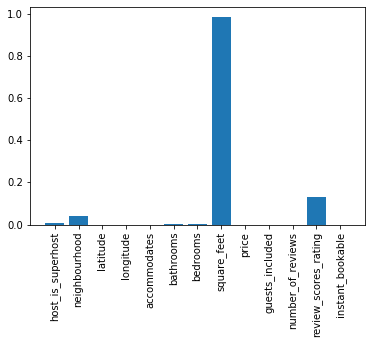

In [8]:
## for each column, check the percentage of NAs

nas = np.zeros(len(kept_columns))
for i, k in enumerate(kept_columns):
    nas[i] = data[k].isna().sum() / len(data)
    
plt.bar(kept_columns, nas)
plt.xticks(rotation=90)
plt.show()

In [9]:
## We reomve square_feet

kept_columns = [c for c in kept_columns if c != "square_feet"]
data = data[kept_columns]

In [10]:
## and drop the NAs
data = data.dropna()

In [11]:
#convert prices to float
def convert_to_float(value):
    # remove ","
    string = value[1:].replace(",","")
    return float(string)

data['price'] = data['price'].apply(lambda x: convert_to_float(x))

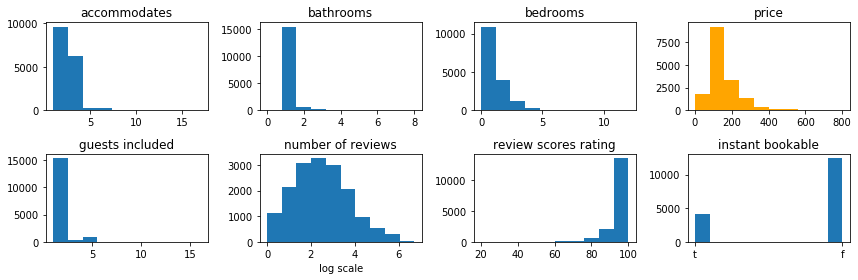

In [12]:
numeric_variables = ["accommodates", "bathrooms", "bedrooms", "price", "guests_included", 
                     "number_of_reviews", "review_scores_rating", "instant_bookable"]

in_log_scale = ["number_of_reviews"]

fig, axes = plt.subplots(2, 4, figsize=(12, 4))
axes = axes.flat

for i, k in enumerate(numeric_variables):
    if k == "price":
        axes[i].hist(data[k].values, range=(0, 800), color="orange")
    elif k in in_log_scale:
        axes[i].hist(np.log(data[k].values))
        axes[i].set_xlabel("log scale")
    else:
        axes[i].hist(data[k].values)
    axes[i].set_title(" ".join(k.split("_")), fontsize=TITLE_FONT_SIZE)
    
    
    
plt.tight_layout()
plt.show()

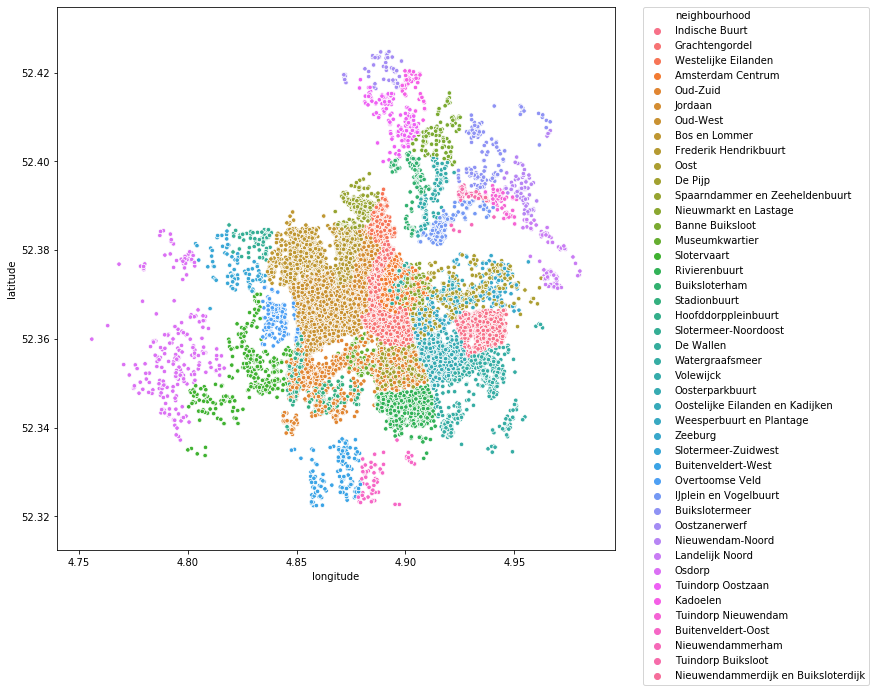

In [13]:
# plot neighbourhoods
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood',s=20, data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [14]:
import geopandas as gpd

In [ ]:
#load geojson
geodf = gpd.read_file('neighbourhoods.geojson')

## Find correspondence between locations and geojson neigh

In [ ]:
#Create a point of each Airbnb location, and enable the "data" dataframe into a geopandas dataframe
datageom = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

#Now, do a spatial join... This code here runs an intersect analysis to find which neighborhood the Airbnb location is in
joined = gpd.sjoin(geodf, datageom, how='inner', op='intersects')
#N.B. some data are removed if not in any polygon

#Rename the column. 
joined.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

#Drop the second geometry column
joined.drop(columns='geometry', inplace=True)

In [ ]:
# plot neighbourhoods
fig,ax1 = plt.subplots(1,1, figsize=(10,10))
base = geodf.plot(color='white',alpha=0.5, edgecolor='black', ax=ax1)
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood',s=20, data=joined)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#Create a count of each neighborhood
nb_join_count = joined.groupby('neighbourhood').agg('count').reset_index()

#Get the "true count". Join this data to the original neighborhoods geometry 
true_count = geodf.merge(nb_join_count, on='neighbourhood')

#Lets plot number of observations in each area
fig,ax = plt.subplots(1,1, figsize=(10,10))

base = geodf.plot(color='white', edgecolor='black', ax=ax)
true_count.plot(column='price',cmap='viridis', ax=base, legend=True)
#plt.title('Number of Airbnb listings by Neighborhood in Amsterdam')
plt.show()

In [ ]:
data_clean = joined[['neighbourhood', 'price']]             

In [ ]:
# convert data to list of lists
grouped = data_clean.groupby(['neighbourhood']).apply(lambda x: x['price'].values.tolist())
neigh = grouped.index.values

l = []
low = 1
up = 1000
for index, value in grouped.items():
    val = np.array(value)
    l.append(val[np.where(np.logical_and(val<up, val>low))[0]])

In [ ]:
# remove empty neigh from geodf
drop_ind = [ i for i in range(geodf.shape[0]) if geodf['neighbourhood'].iloc[i] not in neigh]
geodf.drop(drop_ind, inplace=True, axis=0)
geodf = geodf.reset_index()

In [ ]:
# build W
neigh_map = {k: i for i,k in enumerate(neigh) }

n = len(neigh)
W = np.zeros((n, n))
for index, value in geodf.iterrows():  
    # get 'not disjoint' countries
    neighbors = geodf[~geodf.geometry.disjoint(value.geometry)].neighbourhood.tolist()
    # remove own name from the list
    neighbors = [ name for name in neighbors if value.neighbourhood != name ]
    # get indices
    neighbors_indices = [i for i in range(n) if neigh[i] in neighbors]
    # W is 1 for neighbors
    W[neigh_map[value.neighbourhood], neighbors_indices] = 1   

In [ ]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
#matprint(W)

In [ ]:
j=1
fig,ax1 = plt.subplots(1,1, figsize=(30,30))

ax2 = geodf.plot(color='white',alpha=0.5, edgecolor='black', ax=ax1)
ax3 = geodf.iloc[np.where(geodf['neighbourhood']==neigh[j])[0],:].plot(color='blue',
                                                                       alpha=0.5, edgecolor='black', ax=ax2)

geodf.iloc[np.where(geodf['neighbourhood'].isin(neigh[np.where(W[j,:])[0]]))[0],:].plot(
    color='red',alpha=0.5, edgecolor='black', ax=ax3)
geodf.apply(lambda x: ax3.annotate(s=neigh_map[x.neighbourhood], color='black', 
                                   xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.show()

In [ ]:
# 1 e 15 non sono vicini
W[3,18] = 0
W[18,3] = 0

In [ ]:
# save W and l
import pickle

d={'data':l, 'W':W, 'names':neigh}
with open('/home/riccardo/Desktop/spatial_lda/data/amsterdam.pkl', 'wb') as f:
    pickle.dump(d, f)

In [ ]:
import contextily as ctx
# plot densità stimate
indices = [0, 9, 19, 14]
palette = sns.color_palette()

geodf = geodf.to_crs(epsg=3857)

fig,ax = plt.subplots(1,1, figsize=(20,20))

ax = geodf.plot(fc=(0,0,0,0.1), edgecolor='black', ax=ax)

for i in range(len(indices)):
    ax = geodf.iloc[np.where(geodf['neighbourhood']==neigh[indices[i]])[0],:].plot(color=palette[i],
                                                                       alpha=0.9, edgecolor='black', ax=ax)
ctx.add_basemap(ax, alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_axis_off()
#ax.set_aspect('auto')

#geodf.apply(lambda x: ax.annotate(s=x.neighbourhood, color='black', 
#                                   xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
#plt.show()
plt.savefig('dens_estimates_neigh.pdf')